# Generate single-cell images

Here, we are going to process the previously ingested microscopy images with the [scPortrait](https://github.com/MannLabs/scPortrait) pipeline to generate single-cell images that we can use to asses autophagosome formation at a single-cell level.

In [1]:
import lamindb as ln
from typing import Iterable

from pathlib import Path
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
import bionty as bt

ln.track()

→ connected lamindb: scportrait/examples
→ loaded Transform('9gzJFsXw1f6N000B'), started new Run('BfmKTEVA...') at 2025-03-20 11:43:16 UTC
→ notebook imports: anndata==0.12.0.dev75+g762094b2.d20250317 bionty==1.1.0 lamindb==1.2.0 scportrait==1.3.1.dev0


First, we query for the raw and annotated microscopy images.

In [2]:
input_images = (
    ln.Artifact.filter(ulabels__name="autophagy imaging")
    .filter(description__icontains="raw image")
    .filter(suffix=".tif")
)

The experiment contains different genotypes (`WT` and `EI24KO`) that were treated differently (`unstimulated` vs `14h Torin-1`).
For each condition multiple clonal cell lines and imaged multiple FOVs in all of the imaging channels are available.
To properly process this dataset we will need to get single-cell images from each FOV indivdually and tag them with all of the appropriate metadata so that we can identify genotype, treatment condition, clonal cell line and imaging experiment. 

In [3]:
select_artifacts_df = ln.Artifact.filter(ulabels__name="autophagy imaging").filter(description__icontains="raw image").df(features=True)
display(select_artifacts_df.head())

conditions = list(set.union(*select_artifacts_df["stimulation"].values))
cell_line_clones = list(set.union(*select_artifacts_df["cell_line_clone"].values))
FOVs = list(set.union(*select_artifacts_df["FOV"].values))

,uid,key,description,genotype,stimulation,cell_line_clone,channel,imaged structure,study,FOV,magnification,microscope,resolution
id,,,,,,,,,,,,,
384,9BmbViqMmlVhpfS00000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{EI24KO},{14h Torin-1},{U2OS lcklip-mNeon mCherryLC3B EI24 KO clone 1},{mCherry},{mCherry-LC3B},{autophagy imaging},{FOV2},{20X},{Opera Phenix},{0.597976081}
399,Md4OouMExlWS2YfZ0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{WT},{14h Torin-1},{U2OS lcklip-mNeon mCherryLC3B clone 1},{Alexa488},{LckLip-mNeon},{autophagy imaging},{FOV1},{20X},{Opera Phenix},{0.597976081}
397,fOQSb7JCK67aeN6a0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{WT},{14h Torin-1},{U2OS lcklip-mNeon mCherryLC3B clone 2},{DAPI},{DNA},{autophagy imaging},{FOV2},{20X},{Opera Phenix},{0.597976081}
405,YuyVn060M4FxATPz0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{WT},{untreated},{U2OS lcklip-mNeon mCherryLC3B clone 2},{mCherry},{mCherry-LC3B},{autophagy imaging},{FOV2},{20X},{Opera Phenix},{0.597976081}
379,Gtwi9Pcyx8maQEWB0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{WT},{untreated},{U2OS lcklip-mNeon mCherryLC3B clone 1},{Alexa488},{LckLip-mNeon},{autophagy imaging},{FOV1},{20X},{Opera Phenix},{0.597976081}


Alternatively, you can also query for the Ulabel's directly.

In [4]:
conditions = ln.ULabel.filter(links_artifact__feature__name="stimulation", artifacts__in=input_images).distinct()
cell_line_clones = ln.ULabel.filter(links_artifact__feature__name="cell_line_clone", artifacts__in=input_images).distinct()
FOVs = ln.ULabel.filter(links_artifact__feature__name="FOV", artifacts__in=input_images).distinct()

By iterating through conditions, celllines and FOVs, we should only have the 3 images showing a single FOV. By ingesting our common config file we can now process them in scPortrait.

In [5]:
# load config file for processing all datasets
config_file_af = ln.Artifact.get(key="input_data_imaging_usecase/config.yml")
config_file_af.description = (
    "config for scportrait for processing of cells stained for autophagy markers"
)
config_file_af.save()

# annotate the config file with the metadata relevant to the study
config_file_af.features.add_values(
    {"study": "autophagy imaging", "artifact type": "scportrait config"}
)

Lets take a look at the processing of one example FOV.

In [6]:
# get input images for one example FOV
condition = conditions[0]
cellline = cell_line_clones[0]
FOV = FOVs[0]

images = (
            input_images.filter(ulabels=condition)
            .filter(ulabels=cellline)
            .filter(ulabels=FOV)
            .distinct()
            )

# Perform quick sanity check that we only have images which share all of their attributed except channel and imaged structure
_features = []
values_to_ignore = ["channel", "imaged structure"]

for af in images:
    features = af.features.get_values()
    features = {
        key: features[key] for key in features.keys() if key not in values_to_ignore
    }
    _features.append(features)
assert all([_features[0] == f for f in _features])
shared_features = _features[0]

# bring image paths into the correct order for processing
paths = [
        images.filter(ulabels__name=channel_name).one().cache()
        for channel_name in ["DAPI", "Alexa488", "mCherry"]
    ]


In [7]:
# define and create an output location for the processed data
output_directory = "processed_data"
Path(output_directory).mkdir(parents=True, exist_ok=True)

# initialize our scportrait project with a unique ID
unique_project_id = f"{shared_features['cell_line_clone']}/{shared_features['stimulation']}/{shared_features['FOV']}".replace(
        " ", "_"
    )

# create the project location
project_location = f"{output_directory}/{unique_project_id}/scportrait_project"
Path(project_location).mkdir(parents=True, exist_ok=True)

# initialize the project
project = Project(
    project_location=project_location,
    config_path=config_file_af.cache(),
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    overwrite=True,
)

# load our input images
project.load_input_from_tif_files(
    paths, overwrite=True, channel_names=["DAPI", "Alexa488", "mCherry"]
)

# process the project
project.segment()
project.extract()

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         processed_data/U2OS_lcklip-mNeon_mCherryLC3B_EI24_KO_clone_2/untreated/FOV1/scportrait_project/scportrait.
         sdata                                                                                                     


Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

First, lets look at the input images we processed.

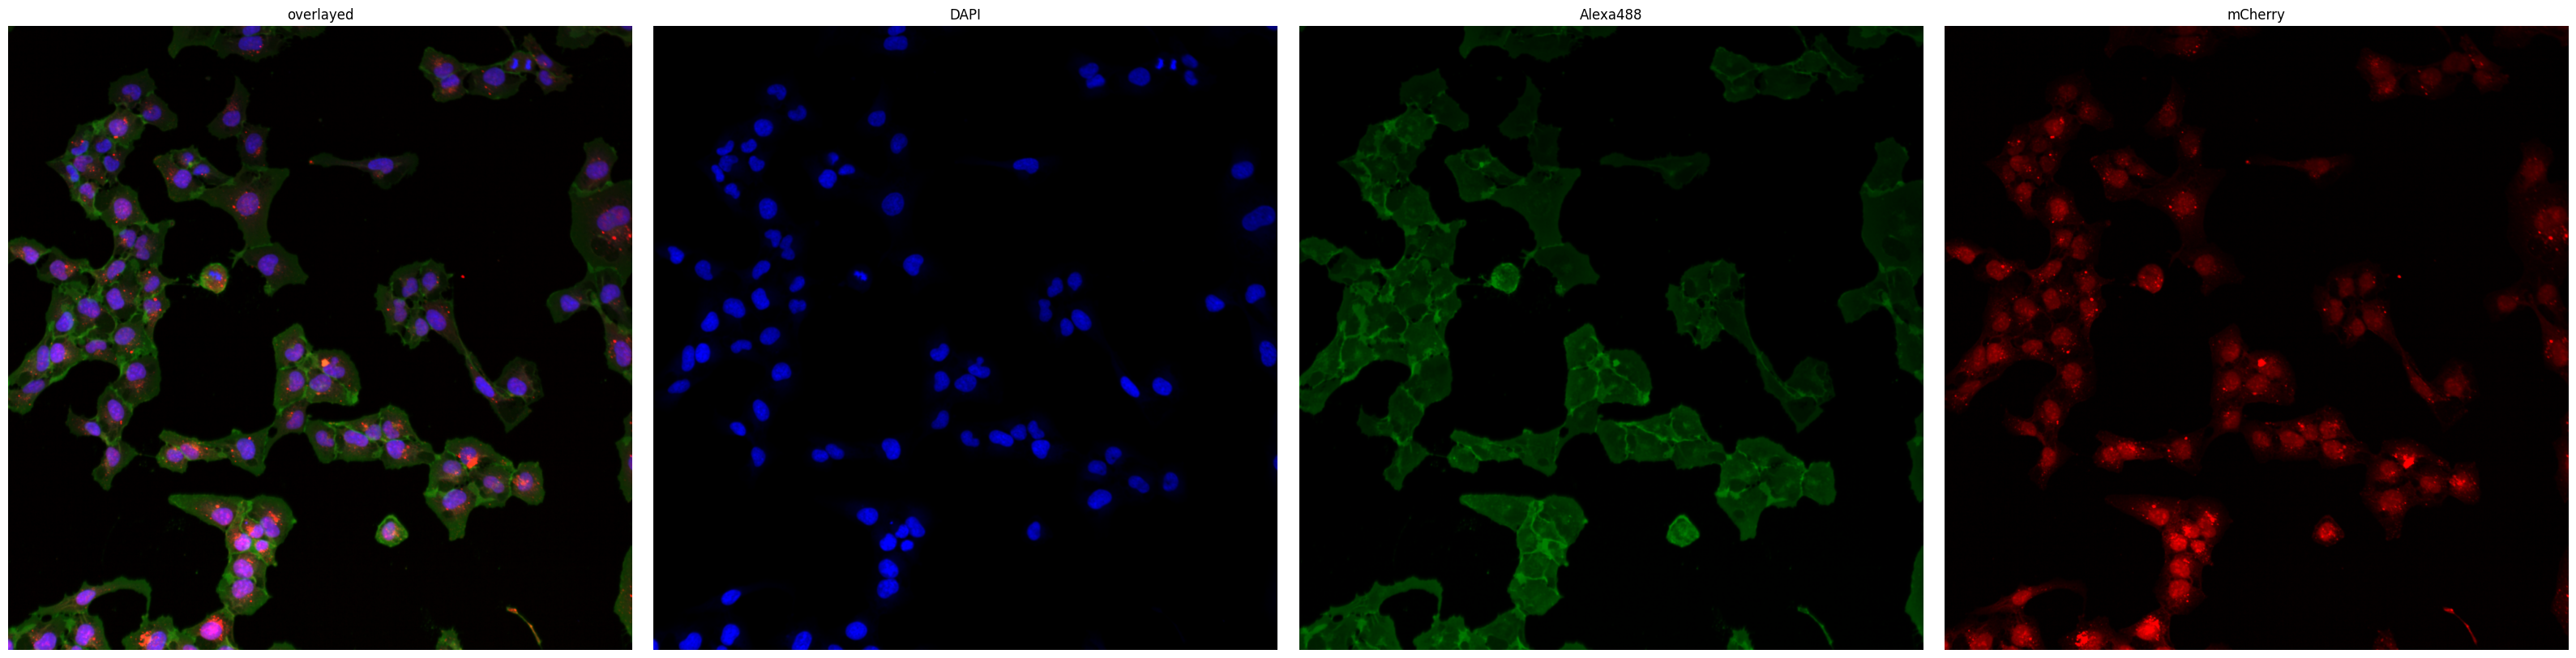

In [8]:
project.plot_input_image()

Now we can look at the results generated by scPortrait. First the segmentation masks.

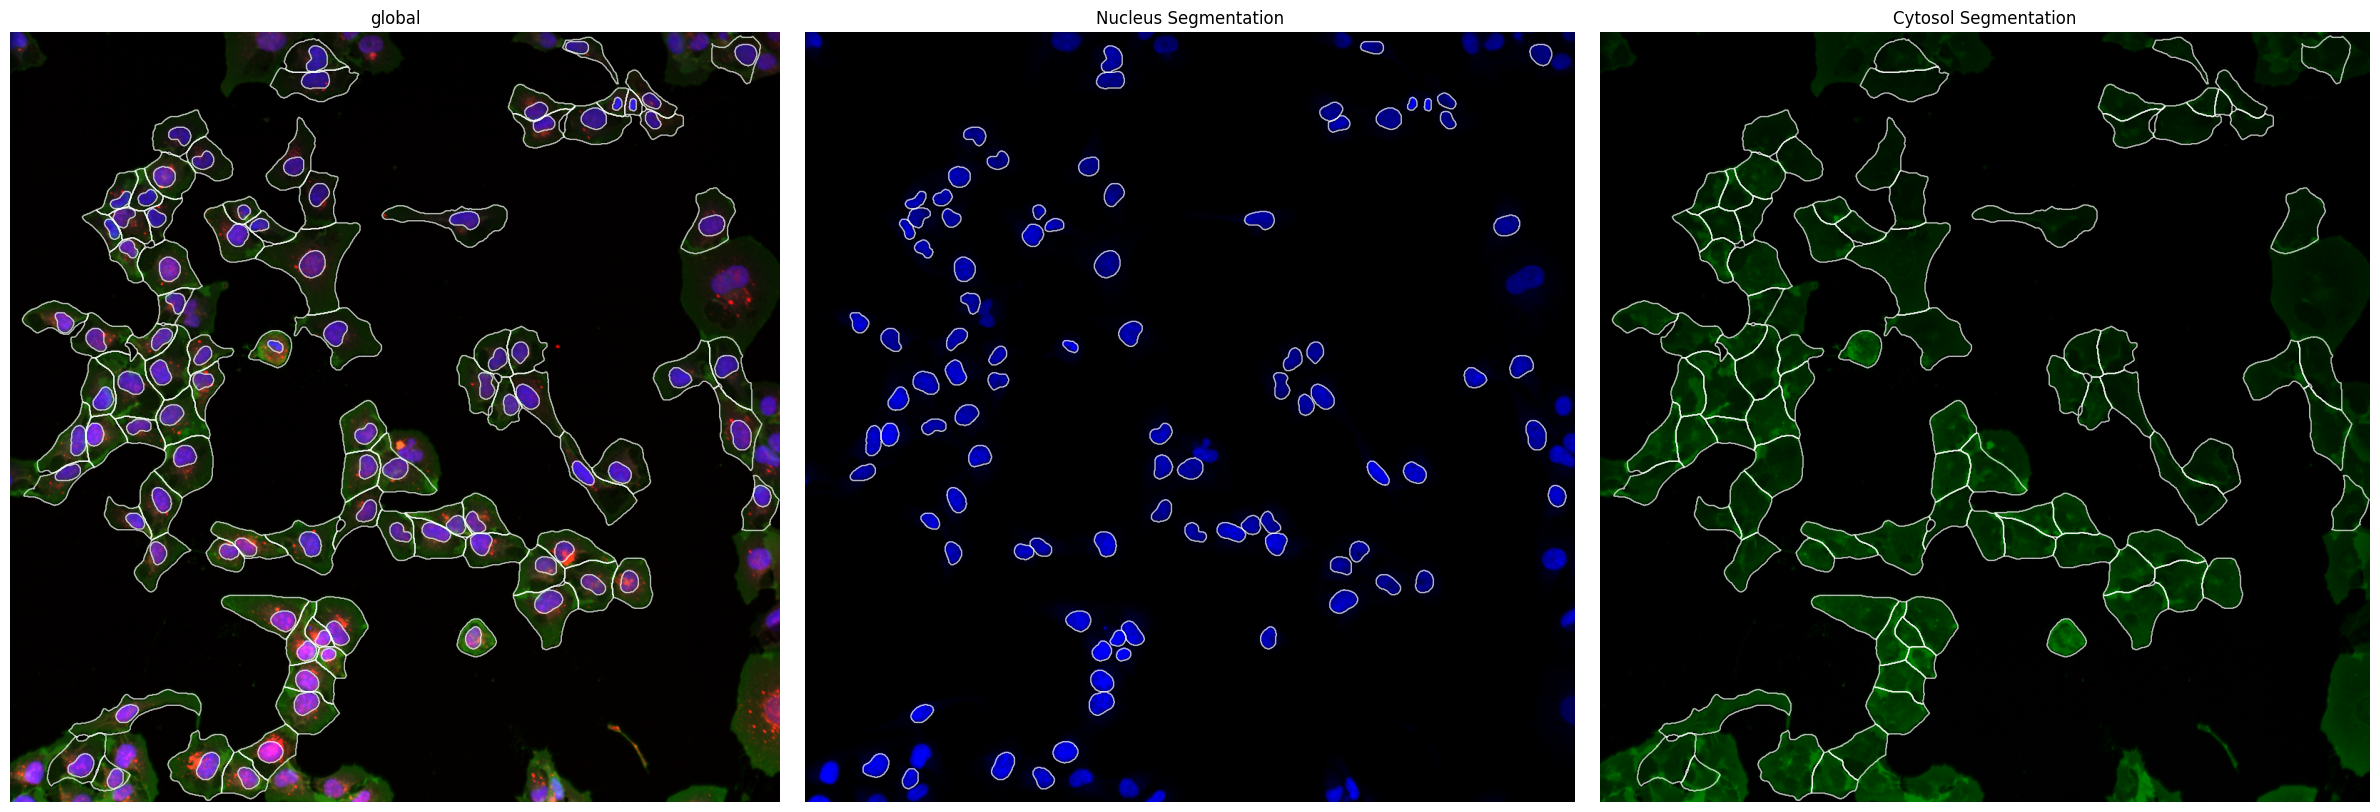

In [9]:
project.plot_segmentation_masks()

And then extraction results consisting of individual single-cell images over all of the channels.

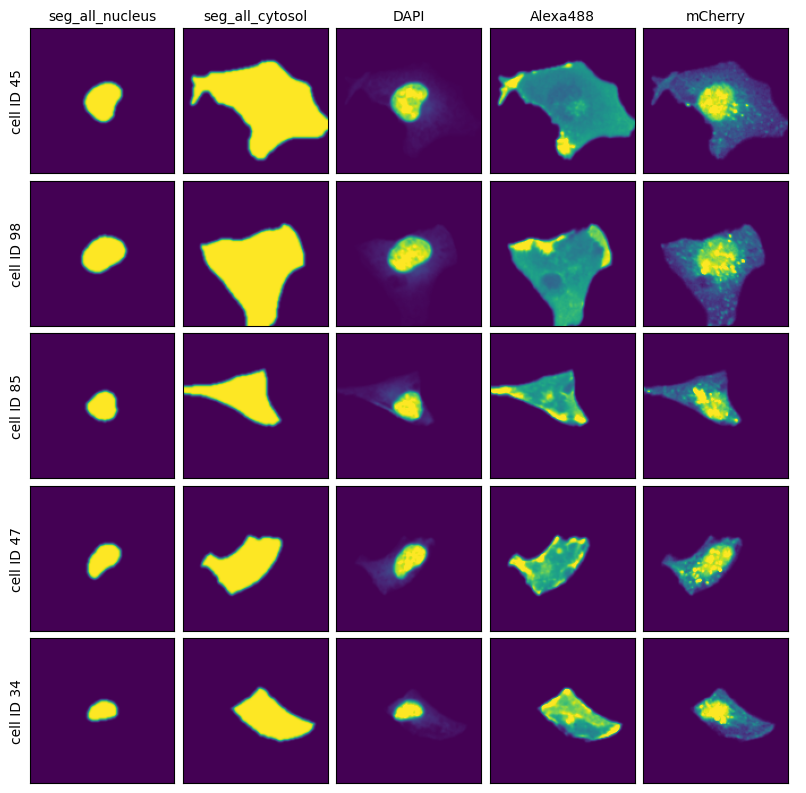

In [10]:
project.plot_single_cell_images()

Now we also want to save these results to our instance. 

In [11]:
# add placeholder annotation to be able to use spatialdata curator
from anndata import AnnData
sdata = project.sdata 
centers = sdata["centers_seg_all_nucleus"].compute()
obs = centers.index.to_frame()
obs.columns = ["cell_id"]
adata = AnnData(centers, obs = obs)

project.filehandler._write_table_sdata(adata, "centers_seg_all_nucleus_table", "seg_all_nucleus", overwrite=True)

# upload the segmentation results saved as a spatialdata object
sdata = project.filehandler.get_sdata()

#update annotation with shared features
annotation = shared_features.copy()
annotation["filetype"] = "spatialdata"
sdata.attrs["sample"] = annotation

curator = ln.Curator.from_spatialdata(
    sdata,
    var_index = {"centers_seg_all_nucleus_table": bt.Gene.symbol},
    categoricals = {"centers_seg_all_nucleus_table": {"region": ln.ULabel.name}},
    organism = "human"
)
curator.validate()
curator.add_new_from_var_index("centers_seg_all_nucleus_table")
curator.add_new_from(key = "region", accessor="centers_seg_all_nucleus_table")

curator.save_artifact(description = "scportrait spatialdata object containing results of cells stained for autophagy markers", 
                      key = f"processed_data_imaging_use_case/{unique_project_id}/spatialdata.zarr",)

/Users/sophia/Documents/GitHub/anndata/src/anndata/_core/aligned_df.py:83: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


! indexing datasets with gene symbols can be problematic: https://docs.lamin.ai/faq/symbol-mapping
• validating categoricals of table 'centers_seg_all_nucleus_table' ...
✓ "var_index" is validated against Gene.symbol
✓ "region" is validated against ULabel.name

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /Users/sophia/Library/Caches/lamindb/x9wwBBolMjvhM1cH0000.zarr). Please see the         
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from                                                              
         processed_data/U2OS_lcklip-mNeon_mCherryLC3B_EI24_KO_clone_2/untreated/FOV1/scportrait_project/scportrait.
         sdata the new file path: /Users/s

Artifact(uid='lZWBm5i7vyiW87SC0003', is_latest=True, key='processed_data_imaging_use_case/U2OS_lcklip-mNeon_mCherryLC3B_EI24_KO_clone_2/untreated/FOV1/spatialdata.zarr', description='scportrait spatialdata object containing results of cells stained for autophagy markers', suffix='.zarr', kind='dataset', otype='SpatialData', size=7301194, hash='p-rMR4QP4C9oFpu1AQQhzA', n_files=107, space_id=1, storage_id=1, run_id=746, created_by_id=4, created_at=2025-03-18 11:54:28 UTC)

In [12]:
import lamindb as ln
import bionty as bt

# define var schema
var_schema = ln.Schema(
    name="single-cell image dataset schema var",
    description = "column schema for data measured in obsm[single_cell_images]",
    itype=ln.Feature,
    dtype=float,
).save()

# #define obs schema
obs_schema = ln.Schema(
    name="single-cell image dataset schema obs",
    features=[
        ln.Feature(name="cell_id", dtype="uint").save(),
        ],
).save()

#define uns schema
uns_schema = ln.Schema(
    name="single-cell image dataset schema uns",
    itype=ln.Feature,
    dtype = dict,
).save()

# define composite schema
h5sc_schema = ln.Schema(
    name="single-cell image dataset",
    otype="AnnData",
    components={"var": var_schema, "obs": obs_schema, "uns": uns_schema},
).save()

# curate an AnnData
curator = ln.curators.AnnDataCurator(project.h5sc, h5sc_schema)
curator.validate()
artifact = curator.save_artifact(key = f"processed_data_imaging_use_case/{unique_project_id}/single_cell_data.h5ad")

# add shared annotation
annotation = shared_features.copy()
annotation["imaged structure"] = [
    ln.ULabel.get(name=structure_name)
    for structure_name in ["LckLip-mNeon", "DNA", "mCherry-LC3B"]
]

artifact.features.add_values(annotation)
artifact.labels.add(ln.ULabel.get(name="scportrait single-cell images"))
# # assert artifact.schema == anndata_schema

→ returning existing schema with same hash: Schema(uid='QFjuwsQl5whiq5lYDefF', name='single-cell image dataset schema var', description='column schema for data measured in obsm[single_cell_images]', n=-1, dtype='float', itype='Feature', is_type=False, hash='2LXd3Ex5pNOrDsqEiHkuVw', minimal_set=True, ordered_set=False, maximal_set=False, space_id=1, created_by_id=4, run_id=767, created_at=2025-03-18 16:51:38 UTC)
→ returning existing Feature record with same name: 'cell_id'
→ returning existing schema with same hash: Schema(uid='gtSc25IAAZZuHm5OofnG', name='single-cell image dataset schema obs', n=1, itype='Feature', is_type=False, hash='dq7BaZC5FnFXnMlYqmMwfw', minimal_set=True, ordered_set=False, maximal_set=False, space_id=1, created_by_id=4, run_id=746, created_at=2025-03-15 16:58:10 UTC)
→ returning existing schema with same hash: Schema(uid='PPuGhzVaCCUS7I0HwWgW', name='single-cell image dataset schema uns', n=-1, dtype='dict', itype='Feature', is_type=False, hash='eM1K4iIPtsi5Lc7

To make our lives easier so that we can process all of the files in our dataset we are going to write a custom image processing function.
We decorate this function with :func:`~lamindb.tracked` to track data lineage of the input and output Artifacts. To improve processing time we will only recompute datasets that have not been previously processed and uploaded to our instance.

In [13]:
@ln.tracked()
def _process_images(
    config_file_af: ln.Artifact,
    input_artifacts: Iterable[ln.Artifact],
    h5sc_schema: ln.Schema,
    output_directory: str,
) -> None:

    # Perform quick sanity check that we only have images which share all of their attributes except channel and imaged structure
    _features = []
    values_to_ignore = ["channel", "imaged structure"]

    for af in input_artifacts:
        features = af.features.get_values()
        features = {
            key: features[key] for key in features.keys() if key not in values_to_ignore
        }
        _features.append(features)
    assert all([_features[0] == f for f in _features])
    shared_features = _features[0]

    # create a unique identifier for the project based on the annotated features
    unique_project_id = f"{shared_features['cell_line_clone']}/{shared_features['stimulation']}/{shared_features['FOV']}".replace(
        " ", "_"
    )

    # check if processed results already exist and if so skip processing
    try:
        # check for single-cell images
        (ln.Artifact.get(key =f"processed_data_imaging_use_case/{unique_project_id}/single_cell_data.h5ad")
        )

        # check for spatialdata object
        (ln.Artifact.get(key = f"processed_data_imaging_use_case/{unique_project_id}/spatialdata.zarr")
        )

        print("Dataset already processed and results uploaded to instance. Skipping processing.")

    except:
        # get the paths to the input images
        paths = [
            input_artifacts.filter(ulabels__name=channel_name).one().cache()
            for channel_name in ["DAPI", "Alexa488", "mCherry"]
        ]

        # create the project location
        project_location = f"{output_directory}/{unique_project_id}/scportrait_project"
        Path(project_location).mkdir(parents=True, exist_ok=True)

        project = Project(
            project_location=project_location,
            config_path=config_file_af.cache(),
            segmentation_f=CytosolSegmentationCellpose,
            extraction_f=HDF5CellExtraction,
            overwrite=True,
        )

        # process the project
        project.load_input_from_tif_files(
            paths, overwrite=True, channel_names=["DAPI", "Alexa488", "mCherry"]
        )
        project.segment()
        project.extract()

        # ingest results to instance

        # single-cell images
        curator = ln.curators.AnnDataCurator(project.h5sc, h5sc_schema)
        artifact = curator.save_artifact(key = f"processed_data_imaging_use_case/{unique_project_id}/single_cell_data.h5ad")
        annotation = shared_features.copy()
        annotation["imaged structure"] = [
            ln.ULabel.get(name=structure_name)
            for structure_name in ["LckLip-mNeon", "DNA", "mCherry-LC3B"]
        ]
        artifact.features.add_values(annotation)
        artifact.labels.add(ln.ULabel.get(name="scportrait single-cell images"))

        # spatialdata object
        sdata = project.filehandler.get_sdata()
        centers = sdata["centers_seg_all_nucleus"].compute()
        obs = centers.index.to_frame()
        obs.columns = ["cell_id"]
        adata = AnnData(centers, obs = obs)

        project.filehandler._write_table_sdata(adata, "centers_seg_all_nucleus_table", "seg_all_nucleus", overwrite=True)

        sdata = project.filehandler.get_sdata() # update the sdata object

        annotation = shared_features.copy()
        annotation["filetype"] = "spatialdata"
        sdata.attrs["sample"] = annotation

        curator = ln.Curator.from_spatialdata(
            sdata,
            var_index = {"centers_seg_all_nucleus_table": bt.Gene.symbol},
            categoricals = {"centers_seg_all_nucleus_table": {"region": ln.ULabel.name}},
            organism = "human"
        )
        curator.validate()

        curator.save_artifact(description = "scportrait spatialdata object containing results of cells stained for autophagy markers", 
                              key = f"processed_data_imaging_use_case/{unique_project_id}/spatialdata.zarr",)

    return(None)

ln.Param(name="output_directory", dtype="str").save()

→ returning existing Param record with same name: 'output_directory'


Param(name='output_directory', dtype='str', is_type=False, space_id=1, created_by_id=4, run_id=28, created_at=2025-02-05 14:37:33 UTC)

Now we are ready to process all of our input images and upload the generated single-cell image datasets back to lamin.

In [14]:
for condition in conditions:
    for cellline in cell_line_clones:
        for FOV in FOVs:
            images = (
                input_images.filter(ulabels=condition)
                .filter(ulabels=cellline)
                .filter(ulabels=FOV)
                .distinct()
            )

            _process_images(
                config_file_af,
                input_artifacts=images,
                h5sc_schema=h5sc_schema,
                output_directory=output_directory,
            )

! cannot infer feature type of: <QuerySet [Artifact(uid='QDPX1ljp0eCMz80o0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well08_Alexa488_zstack001_r001_c003.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='Y1bgVRJGzIEhKFGP54fplA', space_id=1, storage_id=1, run_id=674, created_by_id=4, created_at=2025-03-07 13:51:24 UTC), Artifact(uid='Cvamog4G3a2XYGM80000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well08_DAPI_zstack001_r001_c003.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='UFjAP7uBiaM9ivE4hJzHTA', space_id=1, storage_id=1, run_id=674, created_by_id=4, created_at=2025-03-07 13:51:25 UTC), Artifact(uid='6uUjyphUD4D1Hixc0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well08_mCherry_zstack001_r001_c003.tif', description='raw image of U2OS cells stained for autophagy ma

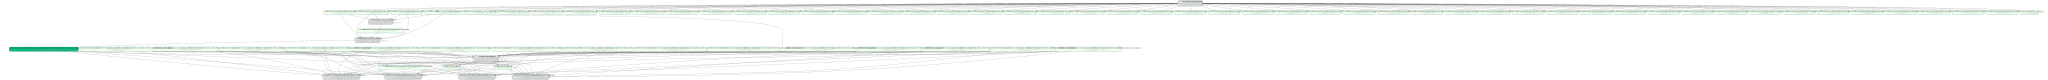

In [15]:
example_artifact = ln.Artifact.filter(
    ulabels=ln.ULabel.get(name="scportrait single-cell images")
)[0]
example_artifact.view_lineage()

In [17]:
ln.finish()

! returning transform with same hash: Transform(uid='9gzJFsXw1f6N000A', is_latest=False, key='imaging2.ipynb', description='Generate single-cell images', type='notebook', hash='mFjd4D3aGi4MOnSnwnEqhA', space_id=1, created_by_id=4, created_at=2025-03-18 16:57:13 UTC)
→ finished Run('BfmKTEVA') after 10m at 2025-03-20 11:54:00 UTC
→ go to: https://lamin.ai/scportrait/examples/transform/9gzJFsXw1f6N000A
→ to update your notebook from the CLI, run: lamin save /Users/sophia/Documents/GitHub/lamin-usecases/docs/imaging2.ipynb
